In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer, util
from sklearn.cluster import MeanShift

from sklearn.metrics import silhouette_score

import seaborn as sns
import matplotlib.pyplot as plt

c:\Users\babeysinghe\AppData\Local\anaconda3\envs\deploy\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
c:\Users\babeysinghe\AppData\Local\anaconda3\envs\deploy\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data = pd.read_feather('ESP.feather')
data.assign(authors=data.authors.str.replace('<#>', ';'))[['authors', 'title', 'pub_date', 'abstract', 'cite_count', 'doi', 'pii', 'openaccess']]

,authors,title,pub_date,abstract,cite_count,doi,pii,openaccess
0,"Zhang, Fengxiu;Xiang, Tianyi",Attending to the unattended: Why and how do lo...,2024-12-31,Research and practice in climate risk reductio...,0,10.1016/j.envsci.2024.103892,S1462901124002260,false
1,"Yoshida, Yuki;Sitas, Nadia;Mannetti, Lelani;O’...",Beyond Academia: A case for reviews of gray li...,2024-12-31,Gray literature is increasingly considered to ...,0,10.1016/j.envsci.2024.103882,S1462901124002168,true
2,"Pietrzyk-Kaszyńska, Agata;Olszańska, Agnieszka",Of heroes and villains – How coalitions shape ...,2024-12-31,Policy narrative analyses provide important in...,0,10.1016/j.envsci.2024.103899,S1462901124002338,false
3,"Zurba, Melanie;Suchet-Pearson, Sandie;Bullock,...",Enhancing meaningful Indigenous leadership and...,2024-12-31,This is the first global empirical study that ...,0,10.1016/j.envsci.2024.103864,S1462901124001989,true
4,"Lemke, Leonard Kwhang-Gil;Beier, Julia;Hanger-...",Exploring procedural justice in stakeholder id...,2024-12-31,"In the face of complex societal challenges, st...",0,10.1016/j.envsci.2024.103900,S146290112400234X,true
...,...,...,...,...,...,...,...,...
4009,"Danila, Donald J",Estimating the abundance and egg production of...,2000-09-01,The winter flounder is a coastal flatfish with...,9,10.1016/S1462-9011(00)00059-9,S1462901100000599,false
4010,"Lorda, Ernesto;Danila, Donald J.;Miller, John D.",Application of a population dynamics model to ...,2000-09-01,A major concern of the Connecticut Department ...,7,10.1016/S1462-9011(00)00061-7,S1462901100000617,false
4011,"Jager, Henriëtte I;Lepla, Ken;Chandler, James;...",Population viability analysis of white sturgeo...,2000-09-01,Many utilities face conflicts between two goal...,13,10.1016/S1462-9011(00)00063-0,S1462901100000630,false
4012,"Farber, Stephen",Welfare-based ecosystem management: an investi...,2000-09-01,This paper investigates the use of welfare-bas...,1,10.1016/S1462-9011(00)00066-6,S1462901100000666,false


In [4]:
class Preprocessing:
    def __init__(self, X):
        '''
        text - pandas series
        '''
        self.sw = stopwords.words('english')
        self.wnl = WordNetLemmatizer()
        self.ps = PorterStemmer()
        self.X = X

    def _remove_special_chars(self, text):
        return re.sub('[^A-Za-z0-9 ]+', '', text)
    
    def remove_special_chars(self):
        self.X = self.X.apply(self._remove_special_chars)
        return self

    def lower_case(self):
        self.X =  self.X.str.lower()
        return self

    def tokenize(self):
        self.X = self.X.apply(wordpunct_tokenize)
        return self
    
    def remove_stopwords(self):
        self.X = self.X.apply(lambda x: [token for token in x if token not in self.sw])
        return self
    
    def stemmer(self):
        self.X = self.X.apply(lambda x: [self.ps.stem(token) for token in x])
        return self
    
    def lemmatize(self):
        self.X = self.X.apply(lambda x: [self.wnl.lemmatize(token) for token in x])
        return self
    
    def get_text(self):
        return self.X

In [5]:
pp = Preprocessing(data.abstract)
pp.remove_special_chars().lower_case().tokenize().remove_stopwords().lemmatize().get_text()

0       [research, practice, climate, risk, reduction,...
1       [gray, literature, increasingly, considered, c...
2       [policy, narrative, analysis, provide, importa...
3       [first, global, empirical, study, specifically...
4       [face, complex, societal, challenge, stakehold...
                              ...                        
4009    [winter, flounder, coastal, flatfish, spawning...
4010    [major, concern, connecticut, department, envi...
4011    [many, utility, face, conflict, two, goal, gen...
4012    [paper, investigates, use, welfarebased, trade...
4013    [wisconsin, electric, power, company, recogniz...
Name: abstract, Length: 4014, dtype: object

In [6]:
topic_model = BERTopic()
topics, probs = topic_model.fit_transform(pp.X.apply(lambda x: ' '.join(x)))

In [7]:
topic_model.visualize_documents(pp.X.apply(lambda x: ' '.join(x)))

In [11]:
tpc_names = []
for tpc_idx in range(-1, 43):
    tpcs = topic_model.get_topic(tpc_idx)
    tpc_name = []
    for _tpc in tpcs[:3]:
        tpc_name.append(_tpc[0])

    tpc_names.append('_'.join(tpc_name))


topic_map = dict()
for key, val in zip(list(range(-1, 69)), tpc_names):
    topic_map[key] = val

In [12]:
data = (
    data
    .assign(numerical_topic=topics)
    .assign(topic=lambda df_x: df_x.numerical_topic.apply(lambda x:topic_map[x]))
    .assign(pub_year=lambda df_x: df_x.pub_date.apply(lambda x: x.split('-')[0]))
)

data

,authors,title,pub_date,doi,openaccess,pii,cite_count,abstract,numerical_topic,topic,pub_year
0,"Zhang, Fengxiu<#>Xiang, Tianyi",Attending to the unattended: Why and how do lo...,2024-12-31,10.1016/j.envsci.2024.103892,false,S1462901124002260,0,Research and practice in climate risk reductio...,1,climate_adaptation_change,2024
1,"Yoshida, Yuki<#>Sitas, Nadia<#>Mannetti, Lelan...",Beyond Academia: A case for reviews of gray li...,2024-12-31,10.1016/j.envsci.2024.103882,true,S1462901124002168,0,Gray literature is increasingly considered to ...,-1,policy_environmental_change,2024
2,"Pietrzyk-Kaszyńska, Agata<#>Olszańska, Agnieszka",Of heroes and villains – How coalitions shape ...,2024-12-31,10.1016/j.envsci.2024.103899,false,S1462901124002338,0,Policy narrative analyses provide important in...,-1,policy_environmental_change,2024
3,"Zurba, Melanie<#>Suchet-Pearson, Sandie<#>Bull...",Enhancing meaningful Indigenous leadership and...,2024-12-31,10.1016/j.envsci.2024.103864,true,S1462901124001989,0,This is the first global empirical study that ...,24,indigenous_biocultural_people,2024
4,"Lemke, Leonard Kwhang-Gil<#>Beier, Julia<#>Han...",Exploring procedural justice in stakeholder id...,2024-12-31,10.1016/j.envsci.2024.103900,true,S146290112400234X,0,"In the face of complex societal challenges, st...",-1,policy_environmental_change,2024
...,...,...,...,...,...,...,...,...,...,...,...
4009,"Danila, Donald J",Estimating the abundance and egg production of...,2000-09-01,10.1016/S1462-9011(00)00059-9,false,S1462901100000599,9,The winter flounder is a coastal flatfish with...,13,fish_impingement_entrainment,2000
4010,"Lorda, Ernesto<#>Danila, Donald J.<#>Miller, J...",Application of a population dynamics model to ...,2000-09-01,10.1016/S1462-9011(00)00061-7,false,S1462901100000617,7,A major concern of the Connecticut Department ...,13,fish_impingement_entrainment,2000
4011,"Jager, Henriëtte I<#>Lepla, Ken<#>Chandler, Ja...",Population viability analysis of white sturgeo...,2000-09-01,10.1016/S1462-9011(00)00063-0,false,S1462901100000630,13,Many utilities face conflicts between two goal...,13,fish_impingement_entrainment,2000
4012,"Farber, Stephen",Welfare-based ecosystem management: an investi...,2000-09-01,10.1016/S1462-9011(00)00066-6,false,S1462901100000666,1,This paper investigates the use of welfare-bas...,16,wetland_aquatic_water,2000


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24],
 [Text(0, 0, '2000'),
  Text(1, 0, '2001'),
  Text(2, 0, '2002'),
  Text(3, 0, '2003'),
  Text(4, 0, '2004'),
  Text(5, 0, '2005'),
  Text(6, 0, '2006'),
  Text(7, 0, '2007'),
  Text(8, 0, '2008'),
  Text(9, 0, '2009'),
  Text(10, 0, '2010'),
  Text(11, 0, '2011'),
  Text(12, 0, '2012'),
  Text(13, 0, '2013'),
  Text(14, 0, '2014'),
  Text(15, 0, '2015'),
  Text(16, 0, '2016'),
  Text(17, 0, '2017'),
  Text(18, 0, '2018'),
  Text(19, 0, '2019'),
  Text(20, 0, '2020'),
  Text(21, 0, '2021'),
  Text(22, 0, '2022'),
  Text(23, 0, '2023'),
  Text(24, 0, '2024')])

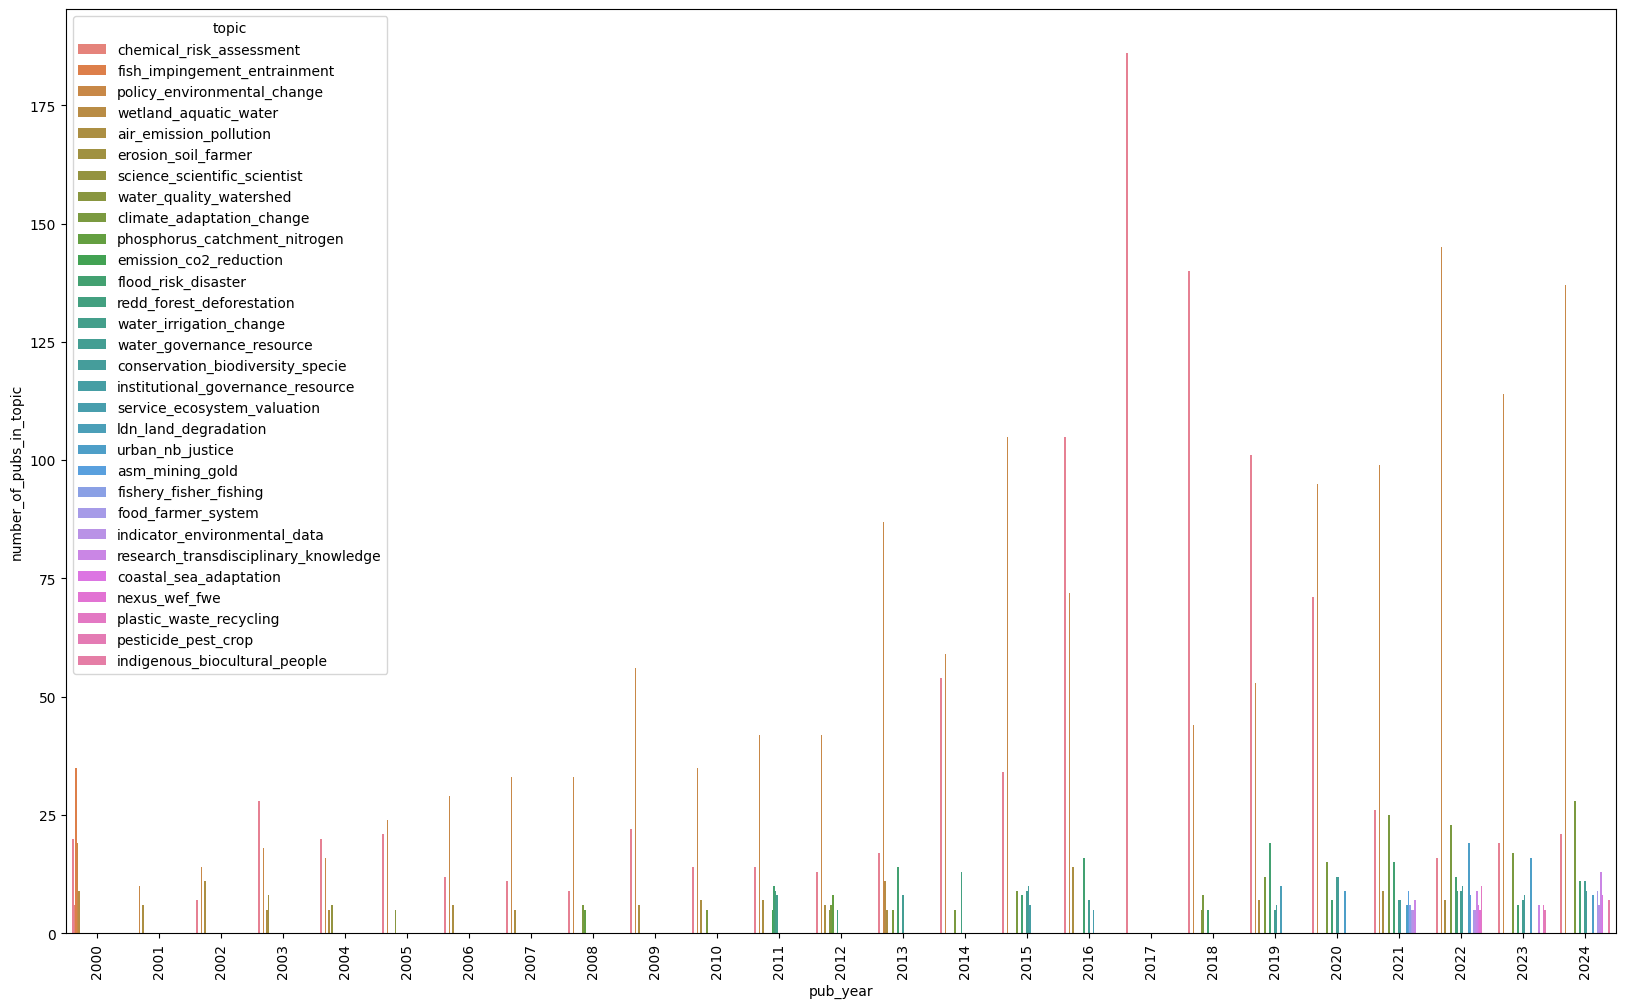

In [13]:

df = data.groupby(['pub_year', 'topic']).topic.agg(number_of_pubs_in_topic='count').reset_index()

df[df.number_of_pubs_in_topic>4]

fig, ax = plt.subplots(figsize=(20, 12))

g = sns.barplot(df.loc[(df.number_of_pubs_in_topic>4)], x='pub_year', y='number_of_pubs_in_topic', hue='topic')
plt.xticks(rotation=90)

In [15]:
topics_over_time = topic_model.topics_over_time(pp.X.apply(lambda x: ' '.join(x)), data.pub_date, nr_bins=24)

topic_model.visualize_topics_over_time(topics_over_time, topics=[2, 36, 16, 3, 7, 24])